# Forecast Scheduling - Wells and WellsGroup Classes

To take advantage of the scheduling capabilities of covering Wells, Scenarios and peroduction periods, two additional classes must be introduced. Like `Scenario` class they are simple wrappers that allows to group multiple scenarios instances on a `Well` instances and multiple `Wells` into a `WellsGroup` Instance. 


In [1]:
import os

from dcapy import dca
from dcapy.schedule import Scenario, Period, Well, WellsGroup
from dcapy.cashflow import CashFlowParams

import numpy as np 
import pandas as pd
from datetime import date, timedelta
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats
import seaborn as sns

Create two scenarios by changing simple parameters that can be denominated as decision variables

In [2]:
#First Period First Scenario

p1a_dict = {
    'name':'pdp',
    'dca': {
        'ti':'2021-01-01',
        'di':0.025,
        'freq_di':'M',
        'qi':1500,
        'b':0,
    },
    'start':'2021-01-01',
    'end':'2040-01-01',
    'freq_output':'A',
    'rate_limit': 300,
    'cashflow_params':[
        {
            'name':'capex',
            'value':{
                'date':['2021-01-01'],
                'value':[-5000000]
                },
            'target':'capex'
        }
    ]
}

#Second Period First Scenario

p2a_dict = {
    'name':'pud',
    'dca': {
        'ti':'2022-01-01',
        'di':0.3,
        'freq_di':'A',
        'qi':3000,
        'b':0,
    },
    'start':'2022-01-01',
    'end':'2040-01-01',
    'freq_output':'A',
    'rate_limit': 100,
    'depends':{'period':'pdp'},
    'cashflow_params':[
        {
            'name':'wo',
            'value':-500000,
            'periods':1,
            'target':'capex'
        },
        {
            'name':'abandon',
            'value':-300000,
            'periods':-1,
            'target':'capex'
        },
    ]
}
s1_dict = {
    'name':'first',
    'periods':[
        p1a_dict,
        p2a_dict
    ],
}
s1 = Scenario(**s1_dict)

In [3]:
#First Period Second Scenario

p1b_dict = {
    'name':'pdp',
    'dca': {
        'ti':'2021-01-01',
        'di':0.025,
        'freq_di':'M',
        'qi':1500,
        'b':0,
    },
    'start':'2021-01-01',
    'end':'2040-01-01',
    'freq_output':'A',
    'rate_limit': 700,
    'cashflow_params':[
        {
            'name':'capex',
            'value':{
                'date':['2021-01-01'],
                'value':[-6500000]
                },
            'target':'capex'
        }
    ]
}

#Second Period Second Escenario

p2b_dict = {
    'name':'pud',
    'dca': {
        'ti':'2022-01-01',
        'di':0.3,
        'freq_di':'A',
        'qi':3000,
        'b':0,
    },
    'start':'2022-01-01',
    'end':'2040-01-01',
    'freq_output':'A',
    'rate_limit': 100,
    'depends':{'period':'pdp'},
    'cashflow_params':[
        {
            'name':'wo',
            'value':-50000,
            'periods':1,
            'target':'capex'
        },
        {
            'name':'abandon',
            'value':-300000,
            'periods':-1,
            'target':'capex'
        },
    ]
}

s2_dict = {
    'name':'second',
    'periods':[
        p1b_dict,
        p2b_dict
    ],
}
s2 = Scenario(**s2_dict)

There have been created two scenarios with more than one period where the dependency option have been set. 

There are capex and rate limit differences between the scenarios.

As seen, there are different ways of creating the instances due to the versatility that Pydantic gives to not only to create but validate them. In this case, the cashflow parameters that applies for all the scenarios can be set once when creating the `Well` instance and passing a list `CashflowParams` directly.

In [4]:
well_1 = Well(
    name = 'well_1',
    scenarios = [s1,s2],
    cashflow_params = [
        CashFlowParams(
            name = 'fix_opex',
            value = -5000,   # 5 KUSD per well per month
            freq_value = 'M',
            target = 'opex',
        ),
        CashFlowParams(
            name = 'var_opex',
            value = -10,     # 10 USD per barrel of oil
            multiply = 'oil_volume',
            target = 'opex',
        ),
        CashFlowParams(
            name = 'Sells',
            value = 50,     # 50 USD per barrel of oil
            multiply = 'oil_volume',
            target = 'income',
            wi = 0.94,
        )
    ]
)

print(type(well_1))

<class 'dcapy.schedule.schedule.Well'>


Generate Forecast and plot it!

/home/scuervo91/dev/apps/dcapy/dcapy/dca/arps.py:240: RuntimeWarning: invalid value encountered in true_divide
  (np.power(qi / rate, b) - 1)/(b * di)
/home/scuervo91/dev/apps/dcapy/dcapy/dca/arps.py:63: RuntimeWarning: divide by zero encountered in true_divide
  return qi/np.power(1+b*di*time_array,1/b)
/home/scuervo91/dev/apps/dcapy/dcapy/dca/arps.py:80: RuntimeWarning: divide by zero encountered in true_divide
  g = np.power(b*di*time_array+1,(b-1)/b)
/home/scuervo91/dev/apps/dcapy/dcapy/dca/arps.py:81: RuntimeWarning: divide by zero encountered in true_divide
  h = np.power(b*di*ti+1,(b-1)/b)
/home/scuervo91/dev/apps/dcapy/dcapy/dca/arps.py:240: RuntimeWarning: invalid value encountered in true_divide
  (np.power(qi / rate, b) - 1)/(b * di)
/home/scuervo91/dev/apps/dcapy/dcapy/dca/arps.py:63: RuntimeWarning: divide by zero encountered in true_divide
  return qi/np.power(1+b*di*time_array,1/b)
/home/scuervo91/dev/apps/dcapy/dcapy/dca/arps.py:80: RuntimeWarning: divide by zero encoun

<AxesSubplot:xlabel='date', ylabel='oil_rate'>

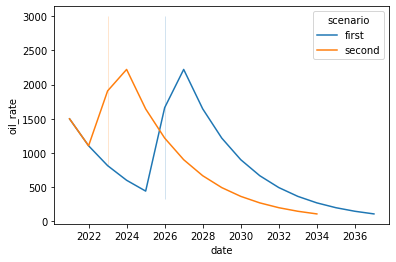

In [5]:
well1_forecast = well_1.generate_forecast(freq_output='A')

#Plot results by scenario
sns.lineplot(data=well1_forecast, x=well1_forecast.index.to_timestamp(), y='oil_rate', hue='scenario')

Generate Cashflows

In [6]:
well1_cashflow = well_1.generate_cashflow(freq_output='A')
print(len(well1_cashflow))

2


In [7]:
well1_cashflow[0].fcf()

,Sells_well_1-first-pdp,Sells_well_1-first-pud,total_income,fix_opex_well_1-first-pdp,var_opex_well_1-first-pdp,fix_opex_well_1-first-pud,var_opex_well_1-first-pud,total_opex,capex_well_1-first-pdp,wo_well_1-first-pud,abandon_well_1-first-pud,total_capex,fcf,cum_fcf
2021,2.218737e+07,0.000000e+00,2.218737e+07,-60000.0,-4.720718e+06,0.0,0.000000e+00,-4.780718e+06,-5000000.0,0.0,0.0,-5000000.0,1.240666e+07,1.240666e+07
2022,1.927792e+07,0.000000e+00,1.927792e+07,-60000.0,-4.101685e+06,0.0,0.000000e+00,-4.161685e+06,0.0,0.0,0.0,0.0,1.511623e+07,2.752289e+07
2023,1.422205e+07,0.000000e+00,1.422205e+07,-60000.0,-3.025969e+06,0.0,0.000000e+00,-3.085969e+06,0.0,0.0,0.0,0.0,1.113608e+07,3.865897e+07
2024,1.050258e+07,0.000000e+00,1.050258e+07,-60000.0,-2.234592e+06,0.0,0.000000e+00,-2.294592e+06,0.0,0.0,0.0,0.0,8.207992e+06,4.686697e+07
2025,7.748154e+06,0.000000e+00,7.748154e+06,-60000.0,-1.648543e+06,0.0,0.000000e+00,-1.708543e+06,0.0,0.0,0.0,0.0,6.039611e+06,5.290658e+07
2026,6.566778e+06,2.223132e+07,2.879810e+07,-60000.0,-1.397187e+06,-60000.0,-4.730067e+06,-6.247254e+06,0.0,-500000.0,0.0,-500000.0,2.205084e+07,7.495742e+07
2027,0.000000e+00,3.870068e+07,3.870068e+07,0.0,0.000000e+00,-60000.0,-8.234188e+06,-8.294188e+06,0.0,0.0,0.0,0.0,3.040649e+07,1.053639e+08
2028,0.000000e+00,2.869882e+07,2.869882e+07,0.0,0.000000e+00,-60000.0,-6.106132e+06,-6.166132e+06,0.0,0.0,0.0,0.0,2.253269e+07,1.278966e+08
2029,0.000000e+00,2.126061e+07,2.126061e+07,0.0,0.000000e+00,-60000.0,-4.523534e+06,-4.583534e+06,0.0,0.0,0.0,0.0,1.667708e+07,1.445737e+08
2030,0.000000e+00,1.572160e+07,1.572160e+07,0.0,0.000000e+00,-60000.0,-3.345020e+06,-3.405020e+06,0.0,0.0,0.0,0.0,1.231658e+07,1.568903e+08


/home/scuervo91/dev/apps/dcapy/dcapy/cashflow/cashflow.py:342: UserWarning: FixedFormatter should only be used together with FixedLocator
  grax.set_yticklabels([fmt.format(i/format_dict[format]['factor']) for i in ticks])
/home/scuervo91/dev/apps/dcapy/dcapy/cashflow/cashflow.py:342: UserWarning: FixedFormatter should only be used together with FixedLocator
  grax.set_yticklabels([fmt.format(i/format_dict[format]['factor']) for i in ticks])


Text(0.5, 1.0, 'Second Scenario')

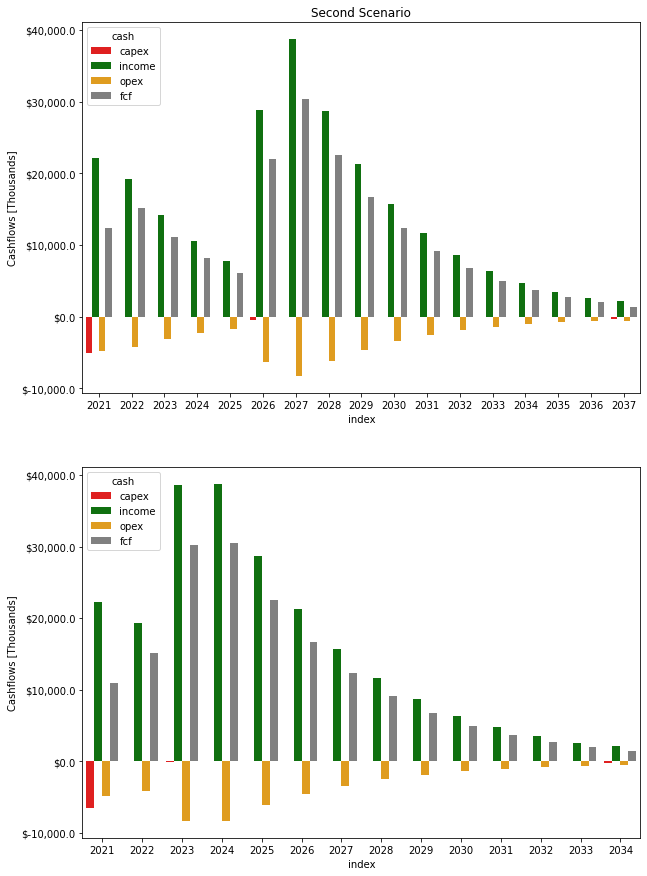

In [8]:

fig, ax = plt.subplots(2,1, figsize=(10,15))

well1_cashflow[0].plot(ax=ax[0])
well1_cashflow[1].plot(ax=ax[1])

ax[0].set_title('First Scenario')
ax[0].set_title('Second Scenario')

In [9]:
well_1.npv([0.1], freq_rate='A', freq_cashflow='A')

,npv,iteration
0.1,1.110744e+08,0
0.1,1.184897e+08,1


In [10]:
well_1.npv([0.1], freq_rate='A', freq_cashflow='A').reset_index().to_dict()


{'index': {0: 0.10000000000000009, 1: 0.10000000000000009},
 'npv': {0: 111074433.96223314, 1: 118489715.93003416},
 'iteration': {0: 0, 1: 1}}